# OUR CODE

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tabulate import tabulate
import os

## Parameters

In [68]:
a0 = 0.0
a1 = -0.22
a2 = -0.18
a3 = -0.08
b1 = 0.5
b2 = 0.25
b3 = 0.25

## Data

### Generate

In [69]:
def generate_data(n_points=500, noise_std=0.1, seed=42):
    np.random.seed(seed)
    v = np.random.normal(0, noise_std, n_points)          # шум v(k)
    eps = np.random.normal(0, noise_std, n_points)        # додатковий шум ε
    y = np.zeros(n_points)

    # початкові значення
    y[0:3] = np.random.normal(0, 0.1, 3)

    for k in range(3, n_points):
        y[k] = (a0 +
                a1*y[k-1] + a2*y[k-2] + a3*y[k-3] +
                v[k] + b1*v[k-1] + b2*v[k-2] + b3*v[k-3] +
                eps[k])
    return y, v

### Load

In [70]:
def load_data():
    data_dir = "data"
    y_file = os.path.join(data_dir, 'y.txt')
    v_file = os.path.join(data_dir, 'v.txt')
    
    if not os.path.exists(y_file) or not os.path.exists(v_file):
        raise FileNotFoundError(f"Required files not found: {y_file}, {v_file}")
    
    y = np.loadtxt(y_file)
    v = np.loadtxt(v_file)
    
    return y, v

## Metrics

In [71]:
def calc_metrics(y_true, y_pred, k_params):
    n = len(y_true)
    S = np.sum((y_true - y_pred)**2)
    R2 = r2_score(y_true, y_pred)
    AIC = n*np.log(S/n) + 2*k_params
    return S, R2, AIC

## Model evaluation

In [72]:
def arcs_model(y, v, p, q, method="ols"):
    n = len(y)
    max_lag = max(p, q)
    X, Y = [], []
    for k in range(max_lag, n):
        row = [1.0]
        for i in range(1, p+1):
            row.append(y[k-i])
        row.append(v[k])
        for j in range(1, q+1):
            row.append(v[k-j])
        X.append(row)
        Y.append(y[k])
    X, Y = np.array(X), np.array(Y)

    if method == "ols":
        model = LinearRegression(fit_intercept=False).fit(X, Y)
        y_pred = model.predict(X)
    else:  # Рекурсивний МНК
        lam, delta = 1.0, 1000
        theta = np.zeros((X.shape[1], 1))
        P = delta * np.eye(X.shape[1])
        y_pred = np.zeros(len(Y))
        for k in range(len(Y)):
            phi_k = X[k].reshape(-1, 1)
            denom = lam + (phi_k.T @ P @ phi_k)
            K = P @ phi_k / denom
            e = Y[k] - (phi_k.T @ theta).item()
            theta = theta + K * e
            P = (P - K @ phi_k.T @ P) / lam
            y_pred[k] = (phi_k.T @ theta).item()
    return calc_metrics(Y, y_pred, X.shape[1])

## Models comparison

In [73]:
def build_wide_table(y, v):
    rows = []
    for p in range(1,4):
        for q in range(1,4):
            S_ols,R2_ols,AIC_ols = arcs_model(y,v,p,q,"ols")
            S_r,R2_r,AIC_r = arcs_model(y,v,p,q,"ridge")
            rows.append({
                "Модель": f"ARCS({p},{q})",
                "МНК S": S_ols, "МНК R²": R2_ols, "МНК AIC": AIC_ols,
                "РМНК S": S_r, "РМНК R²": R2_r, "РМНК AIC": AIC_r
            })
    return pd.DataFrame(rows).set_index("Модель")

## Recursive estimation of coefficients

In [74]:
def recursive_estimation(y, v, p=3, q=3, method="ols"):
    n = len(y)
    max_lag = max(p, q)
    coeffs = []
    theta = None
    P = None
    lam = 1.0

    for t in range(max_lag + p + q + 2, n):
        X_hist, Y_hist = [], []
        for tau in range(max_lag, t+1):
            row = [1.0]
            for i in range(1, p+1):
                row.append(y[tau-i])
            row.append(v[tau])
            for j in range(1, q+1):
                row.append(v[tau-j])
            X_hist.append(row)
            Y_hist.append(y[tau])
        X_hist, Y_hist = np.array(X_hist), np.array(Y_hist)

        if method == "ols":
            model = LinearRegression(fit_intercept=False).fit(X_hist, Y_hist)
            coeffs.append(model.coef_.copy())
        else:
            if theta is None:
                theta = np.zeros((X_hist.shape[1], 1))
                P = 1000 * np.eye(X_hist.shape[1])
            for k in range(len(Y_hist)):
                phi_k = X_hist[k].reshape(-1, 1)
                denom = lam + (phi_k.T @ P @ phi_k)
                K = P @ phi_k / denom
                e = Y_hist[k] - (phi_k.T @ theta).item()
                theta = theta + K * e
                P = (P - K @ phi_k.T @ P) / lam
            coeffs.append(theta.ravel().copy())
    return np.array(coeffs)


## Plots

### Evolution plots

In [75]:
def plot_coefficients_evolution(real_coeffs, est_mnk, est_rmnk):
    names = list(real_coeffs.keys())
    fig, axes = plt.subplots(len(names), 1, figsize=(12, 3*len(names)))
    if len(names) == 1: axes = [axes]
    k = np.arange(est_mnk.shape[0])
    coef_indices = list(range(len(names)))
    for i, (ax, name) in enumerate(zip(axes, names)):
        real_val = real_coeffs[name]
        coef_idx = coef_indices[i]
        ax.axhline(y=real_val, color='k', linestyle='-', linewidth=2, label="Реальне")
        ax.plot(k, est_mnk[:, coef_idx], 'r-', label="МНК")
        ax.plot(k, est_rmnk[:, coef_idx], 'g-', label="РМНК")
        ax.set_title(f"Коефіцієнт {name}")
        ax.legend()
        ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Accuracy plots

In [76]:
def build_table(y, v, max_p=3, max_q=3):
    results_mnk, results_rmnk, labels = [], [], []
    for p in range(1, max_p+1):
        for q in range(1, max_q+1):
            S_mnk, R2_mnk, AIC_mnk = arcs_model(y, v, p, q, "ols")
            S_rmnk, R2_rmnk, AIC_rmnk = arcs_model(y, v, p, q, "ridge")
            results_mnk.append((S_mnk, R2_mnk, AIC_mnk))
            results_rmnk.append((S_rmnk, R2_rmnk, AIC_rmnk))
            labels.append(f"ARCS({p},{q})")
    return labels, np.array(results_mnk), np.array(results_rmnk)

def plot_model_quality(labels, results_mnk, results_rmnk):
    metrics = ["S (∑e²)", "R²", "AIC"]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, ax in enumerate(axes):
        ax.plot(labels, results_mnk[:, i], "r--o", label="МНК")
        ax.plot(labels, results_rmnk[:, i], "g-s", label="РМНК")
        ax.set_title(metrics[i])
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45)
        ax.grid(True, alpha=0.3)
        ax.legend()
    plt.tight_layout()
    plt.show()

## Main

Згенеровано дані для вашої моделі.

Результати 9 моделей (1≤p≤3,1≤q≤3):
+-----------+----------+----------+-------------+----------+----------+-------------+
|  Модель   |  МНК S   |  МНК R²  |   МНК AIC   |  РМНК S  | РМНК R²  |  РМНК AIC   |
+-----------+----------+----------+-------------+----------+----------+-------------+
| ARCS(1,1) | 0.101870 | 0.434556 | -649.447369 | 0.057695 | 0.679752 | -704.024953 |
| ARCS(1,2) | 0.050763 | 0.211149 | -705.773724 | 0.036016 | 0.440322 | -738.379285 |
| ARCS(1,3) | 0.030523 | 0.525665 | -743.060762 | 0.018396 | 0.714123 | -790.657768 |
| ARCS(2,1) | 0.036671 | 0.430140 | -736.666419 | 0.025244 | 0.607713 | -772.139237 |
| ARCS(2,2) | 0.036662 | 0.430273 | -734.688589 | 0.024089 | 0.625667 | -774.589785 |
| ARCS(2,3) | 0.013943 | 0.783318 | -814.707942 | 0.008737 | 0.864228 | -858.648971 |
| ARCS(3,1) | 0.008585 | 0.866593 | -862.300427 | 0.007468 | 0.883949 | -875.402224 |
| ARCS(3,2) | 0.008518 | 0.867626 | -861.031407 | 0.007179 | 0.88844

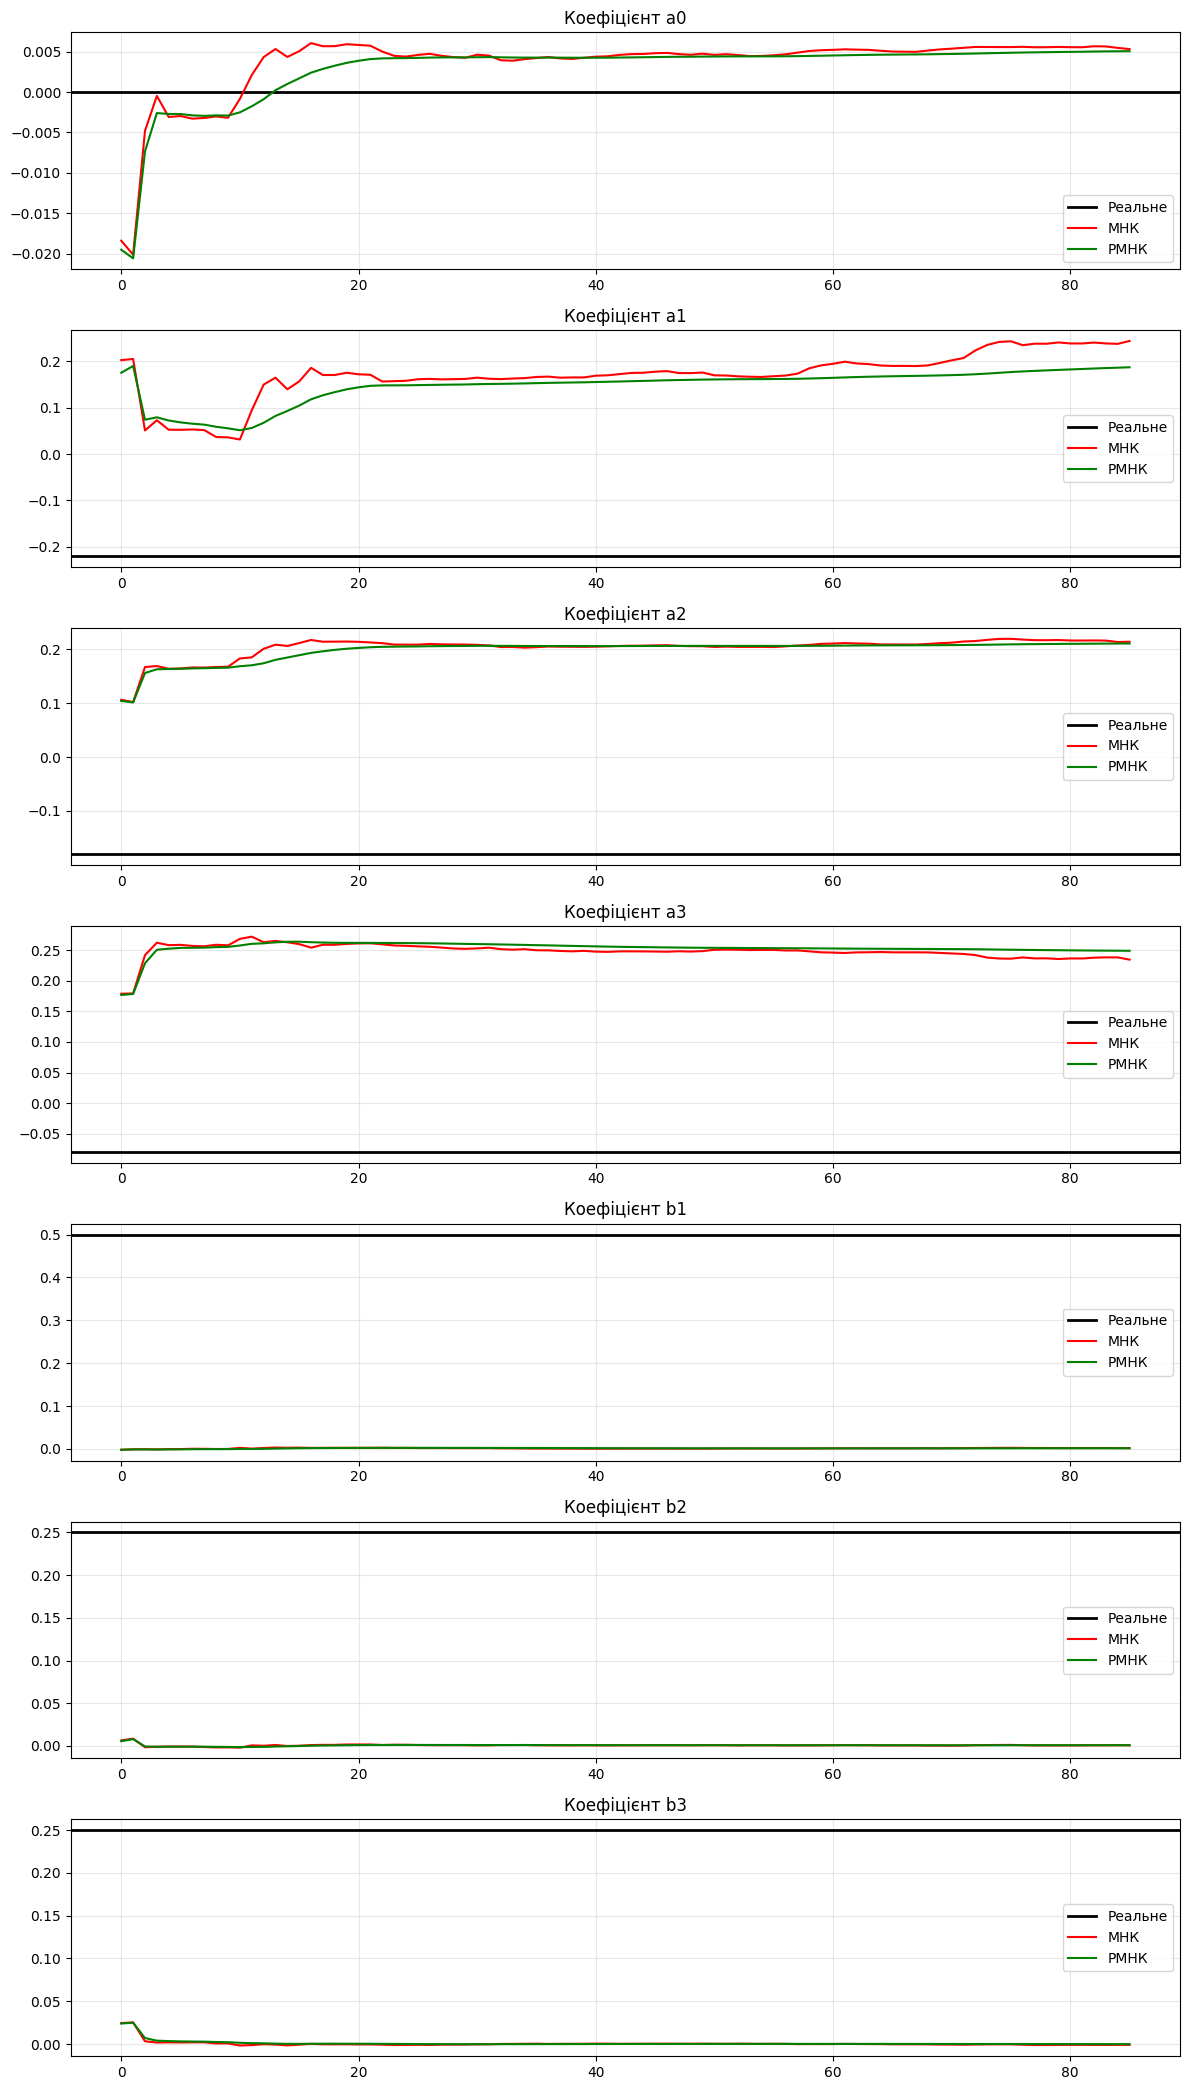

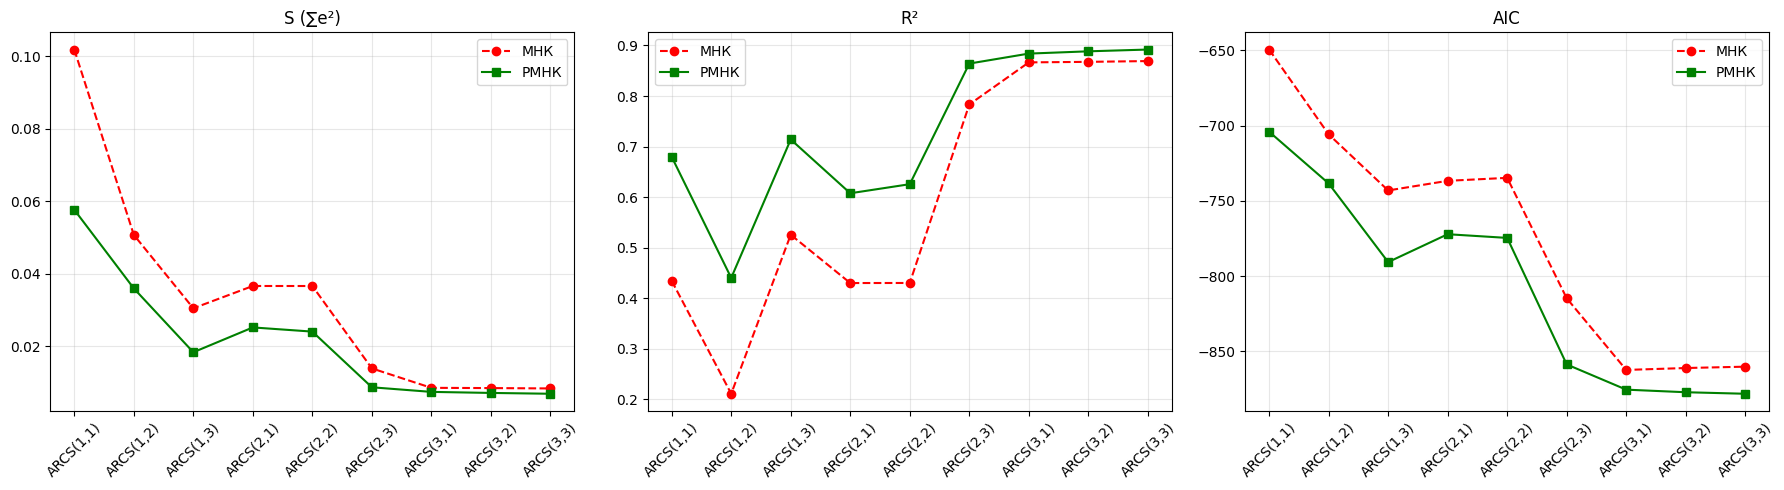

In [80]:
def main():
    results_dir = "results"
    os.makedirs(results_dir, exist_ok=True)

    y, v = load_data()
    print("Згенеровано дані для вашої моделі.")
    df = build_wide_table(y, v)
    float_cols = df.select_dtypes(include=['float']).columns
    df[float_cols] = df[float_cols].map(lambda x: f"{x:.6f}")
    print("\nРезультати 9 моделей (1≤p≤3,1≤q≤3):")
    print(tabulate(df, headers='keys', tablefmt='pretty'))

    csv_path = os.path.join(results_dir, "results_wide.csv")
    df.to_csv(csv_path, index=False)
    print(f"Таблиця збережена у {csv_path}")

    real_coeffs = {"a0": a0, "a1": a1, "a2": a2, "a3": a3,
                   "b1": b1, "b2": b2, "b3": b3}
    est_mnk = recursive_estimation(y, v, p=3, q=3, method="ols")
    est_rmnk = recursive_estimation(y, v, p=3, q=3, method="ridge")
    plot_coefficients_evolution(real_coeffs, est_mnk, est_rmnk)

    labels, results_mnk, results_rmnk = build_table(y, v)
    plot_model_quality(labels, results_mnk, results_rmnk)

if __name__ == "__main__":
    main()


# GPT CODE

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

RUN_CELL = False
if not RUN_CELL:
    raise SystemExit("Skipping this cell")

# ----------------------------
# 1. Генерація або завантаження даних
# ----------------------------
def generate_data(n=500, seed=42):
    np.random.seed(seed)
    v = np.random.normal(0, 0.1, n)
    y = np.zeros(n)
    # приклад стабільної ARMA(2,2) системи
    a = [0.5, -0.3]
    b = [0.7, -0.2]
    for t in range(max(len(a), len(b)), n):
        y[t] = (a[0]*y[t-1] + a[1]*y[t-2] +
                b[0]*v[t-1] + b[1]*v[t-2] + v[t])
    return y, v

def load_or_generate():
    y_file, v_file = Path("y_generated.txt"), Path("v_generated.txt")
    if y_file.exists() and v_file.exists():
        y = np.loadtxt(y_file)
        v = np.loadtxt(v_file)
    else:
        y, v = generate_data()
        np.savetxt(y_file, y)
        np.savetxt(v_file, v)
        print("Файли не знайдено. Згенеровано синтетичні дані і збережено.")
    return y, v

y, v = load_or_generate()
print(f"Середнє y: {y.mean():.4f}, σ(y): {y.std():.4f}")

# ----------------------------
# 2. Побудова матриці регресорів
# ----------------------------
def design_matrix(y, v, p, q):
    n = len(y)
    m = max(p, q)
    X, Y = [], []
    for t in range(m, n):
        row = []
        # AR частина
        for i in range(1, p+1):
            row.append(y[t-i])
        # MA частина
        for j in range(1, q+1):
            row.append(v[t-j])
        X.append(row)
        Y.append(y[t])
    return np.array(X), np.array(Y)

# ----------------------------
# 3. Методи оцінки
# ----------------------------
def ols_estimation(X, Y):
    theta = np.linalg.lstsq(X, Y, rcond=None)[0]
    y_hat = X @ theta
    e = Y - y_hat
    return theta, e

def rls_estimation(X, Y, lam=1.0, delta=1000):
    n_samples, n_params = X.shape
    theta = np.zeros(n_params)
    P = delta * np.eye(n_params)
    thetas = np.zeros((n_samples, n_params))
    for k in range(n_samples):
        xk = X[k, :].reshape(-1, 1)
        denom = lam + (xk.T @ P @ xk).item()
        K = (P @ xk / denom).flatten()
        err = (Y[k] - xk.T @ theta.reshape(-1,1)).item()
        theta = theta + K * err
        P = (P - K[:, None] @ xk.T @ P) / lam
        thetas[k] = theta
    e = Y - X @ theta
    return theta, e, thetas

# ----------------------------
# 4. Перебір моделей p=1..3, q=1..3
# ----------------------------
results = []
rls_paths = {}  # для перехідних процесів

for p in range(1,4):
    for q in range(1,4):
        X, Y = design_matrix(y, v, p, q)

        # OLS
        th_ols, e_ols = ols_estimation(X, Y)

        # RLS
        th_rls, e_rls, thetas_path = rls_estimation(X, Y)
        rls_paths[(p,q)] = thetas_path

        n = len(Y)
        k = p + q
        sse_ols = np.sum(e_ols**2)
        sse_rls = np.sum(e_rls**2)
        r2_ols = 1 - sse_ols/np.sum((Y - Y.mean())**2)
        r2_rls = 1 - sse_rls/np.sum((Y - Y.mean())**2)
        aic_ols = n*np.log(sse_ols/n) + 2*k
        aic_rls = n*np.log(sse_rls/n) + 2*k

        results.append({
            'p': p, 'q': q,
            'R2_OLS': r2_ols,
            'R2_RLS': r2_rls,
            'SSE_OLS': sse_ols,
            'SSE_RLS': sse_rls,
            'AIC_OLS': aic_ols,
            'AIC_RLS': aic_rls
        })

res_df = pd.DataFrame(results)
print(res_df)

# ----------------------------
# 5. Графіки перехідного процесу РМНК
# ----------------------------
for (p,q), path in rls_paths.items():
    plt.figure(figsize=(8,4))
    for i in range(path.shape[1]):
        plt.plot(path[:,i], label=f'θ{i+1}')
    plt.title(f'Перехідний процес RLS для моделі ARXS({p},{q})')
    plt.xlabel('Час k')
    plt.ylabel('Оцінка параметра')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ----------------------------
# 6. Графіки залежностей R2, SSE, AIC
# ----------------------------
def plot_metric(metric_name):
    plt.figure(figsize=(7,4))
    for method in ['OLS','RLS']:
        vals = []
        orders = []
        for _, r in res_df.iterrows():
            orders.append(f"{int(r.p)},{int(r.q)}")
            vals.append(r[f"{metric_name}_{method}"])
        plt.plot(orders, vals, marker='o', label=method)
    plt.title(metric_name + ' vs порядок моделі')
    plt.xlabel('Порядок (p,q)')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metric('R2')
plot_metric('SSE')
plot_metric('AIC')

# Збереження у файл
res_df.to_excel('results_models.xlsx', index=False)
print("\nРезультати збережені у results_models.xlsx")


SystemExit: Skipping this cell

/home/oleksa/repos/personal/TSA-labs/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
